In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# SoftTouch Lenses complete database
conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

# conn = psycopg2.connect(
# host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
#   user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
#   password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
#   database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
#   port = '5432'
# )

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%U')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()
data = data[data['order_status'] != 'cancelled']

In [6]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [7]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [8]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New', 'Churned (Single Use Only)', 'Recent & Loyals', 'Champions', 'Churned (Repeat Use)']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'New Business Drivers', 'High Repeat Products']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()
# avg_delta_days = data["DeltaDaysinOrders"].mean()

for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: np.min(np.sort(x)[-2:])),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()

    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']

    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['value_score'] = userweeklydata['Order_Value'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned (Single Use Only)'

      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyals'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
          return 'Champions'
      else:
          return 'Churned (Repeat Use)'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')

    totalcarts=x3['order_id'].nunique()
    product_level=x3.groupby(['product_name']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
    produser=data.groupby(['product_name','user_id']).agg(
        New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    produser_newcount=produser.groupby('product_name').agg(
        New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
    ).reset_index()
    data_repeat=data[data['TrxnRank']==2]
    produser_repeatcount=data_repeat.groupby('user_id').agg(
        Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
    k.fillna(0)
    k1=k.groupby('product_name').agg(
        Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
    ).reset_index()
    productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
    productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

    productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
    productlevel=productlevel.sort_values('NewRepeatConversionRatio')
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
    def ProductCohortLables2(df):
        if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
            return 'Hero'
        elif df['NewRepeatConversion_score'] >2:
            return 'High Repeat Products'
        elif (df['CP_score'] >2):
            return 'New Business Drivers'
        elif (df['ASP_score'] >3):
            return 'High Value & Slow Moving'
        elif (df['ASP_score'] <=3):
            return 'Low Value & Slow Moving'
        else:
            return 'Low Value & Slow Moving'
    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

    x3=pd.merge(x3,
         productlevel[['product_name','Product Cohort Lables']],
         on="product_name",
         how ='left')


    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),

    ).reset_index()

    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x6 = pd.merge(x5,productlevel[['product_name','Product Cohort Lables']], on='product_name', how='left')
    final_stats = final_stats.append(x6, ignore_index=True)
    final_stats = pd.concat([final_stats, x5], ignore_index=True)

  except:
    pass

In [9]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')
      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']


In [10]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1955 entries, 0 to 1954
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WeekCount              1955 non-null   object 
 1   User_Cohort_Label      1955 non-null   object 
 2   Product Cohort Lables  1955 non-null   object 
 3   totalorders            1955 non-null   int64  
 4   totalusers             1955 non-null   int64  
 5   totalvalue             1955 non-null   float64
 6   quantity               1955 non-null   int64  
 7   SKUCounts              1955 non-null   int64  
 8   newusercount           1022 non-null   float64
 9   CancellationCount      114 non-null    float64
 10  DeliveryCount          1952 non-null   float64
 11  repeatusercount        1022 non-null   float64
 12  AOV                    1955 non-null   float64
 13  Retained_Users         838 non-null    float64
dtypes: float64(7), int64(4), object(3)
memory usage: 229.1+ 

In [11]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [12]:
weekly_summary_stats["User_Cohort_Label"].unique()

array(['Champions', 'Churned (Repeat Use)', 'Churned (Single Use Only)',
       'New', 'Recent & Loyals'], dtype=object)

In [13]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value
0,2020-w38,Champions,New Business Drivers,25,16250.0,0.0,10.0,650.000000
1,2020-w38,Churned (Repeat Use),New Business Drivers,34,22100.0,1.0,13.0,650.000000
2,2020-w38,Churned (Single Use Only),High Repeat Products,1,585.0,0.0,1.0,585.000000
3,2020-w38,Churned (Single Use Only),New Business Drivers,303,196820.0,0.0,303.0,649.570957
4,2020-w38,New,New Business Drivers,313,203385.0,0.0,313.0,649.792332
...,...,...,...,...,...,...,...,...
1950,2023-w52,Churned (Repeat Use),Hero,1,2600.0,0.0,0.0,2600.000000
1951,2023-w52,New,Hero,3,2540.0,0.0,3.0,846.666667
1952,2023-w52,New,New Business Drivers,59,19074.0,0.0,59.0,323.288136
1953,2023-w52,Recent & Loyals,Hero,2,1200.0,0.0,0.0,600.000000


In [14]:
weekly_summary_stats['AOV_Contribution'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [15]:
weekly_summary_stats = weekly_summary_stats.drop("Average_Order_Value", axis=1)

In [16]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "-" + weekly_summary_stats["Product Cohort Lables"]

In [17]:
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)

In [18]:
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [19]:
weekly_summary_stats

,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),AOV_Contribution,key
WeekCount,,,,,,
2020-w38,25,16250.0,0.0,10.0,22.919605,Champions-New Business Drivers
2020-w38,34,22100.0,1.0,13.0,31.170663,Churned (Repeat Use)-New Business Drivers
2020-w38,1,585.0,0.0,1.0,0.825106,Churned (Single Use Only)-High Repeat Products
2020-w38,303,196820.0,0.0,303.0,277.602257,Churned (Single Use Only)-New Business Drivers
2020-w38,313,203385.0,0.0,313.0,286.861777,New-New Business Drivers
...,...,...,...,...,...,...
2023-w52,1,2600.0,0.0,0.0,21.311475,Churned (Repeat Use)-Hero
2023-w52,3,2540.0,0.0,3.0,20.819672,New-Hero
2023-w52,59,19074.0,0.0,59.0,156.344262,New-New Business Drivers


In [20]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [21]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}-{product}' for user, product in all_combinations]

In [22]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [23]:
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(7, len(weeks)):
  try:
      append_week = weeks[i+1]
      week1 = weeks[i]
      week1_df = grouped_dict[week1]
      week2 = weeks[i-1]
      week2_df = grouped_dict[week2]
      week3 = weeks[i-2]
      week3_df = grouped_dict[week3]
      week4 = weeks[i-3]
      week4_df = grouped_dict[week4]
      week5 = weeks[i-4]
      week5_df = grouped_dict[week5]
      week6 = weeks[i-5]
      week6_df = grouped_dict[week6]
      week7 = weeks[i-6]
      week7_df = grouped_dict[week7]
      week8 = weeks[i-7]
      week8_df = grouped_dict[week8]
      week1_df.sort_index(inplace=True)
      week2_df.sort_index(inplace=True)
      week3_df.sort_index(inplace=True)
      week4_df.sort_index(inplace=True)
      week5_df.sort_index(inplace=True)
      week6_df.sort_index(inplace=True)
      week7_df.sort_index(inplace=True)
      week8_df.sort_index(inplace=True)
      average_df = (week1_df + week2_df + week3_df + week4_df + week5_df + week6_df + week7_df + week8_df) / 8
      averages_dict[append_week] = average_df
  except IndexError:
     break

In [24]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [25]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [26]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [27]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [28]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [29]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # curr_week_df = curr_week_df.append(temp_df, ignore_index=True)
        curr_week_df = pd.concat([curr_week_df, temp_df], ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [30]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # avg_week_df = avg_week_df.append(temp_df, ignore_index=True)
        avg_week_df = pd.concat([avg_week_df, temp_df], ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')


In [31]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [32]:
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)

In [33]:
keys_list = list(averages_dict.keys())

In [34]:
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [35]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [36]:
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [37]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)

In [38]:
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'AOV_Contribution', 'No_of_New_Users(First_Time_Users)', '90_Day_Retention']
target_vars = ["Total_Value"]

In [39]:
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'

In [40]:
merged_dataframe

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
0,2020-w46,Churned (Single Use Only)-Low Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory
1,2020-w46,Churned (Single Use Only)-High Value & Slow Mo...,0.000000,0.000000,Secondary_Explanatory
2,2020-w46,Churned (Single Use Only)-High Repeat Products,0.000000,73.125000,Secondary_Explanatory
3,2020-w46,Total_Orders,179.000000,201.875000,Primary_Explanatory
4,2020-w46,Champions-Hero,4999.000000,1832.000000,Secondary_Explanatory
...,...,...,...,...,...
4945,2023-w52,Total_Orders,122.000000,998.250000,Primary_Explanatory
4946,2023-w52,Churned (Repeat Use)-New Business Drivers,0.000000,2978.125000,Secondary_Explanatory
4947,2023-w52,AOV_Contribution,558.016393,484.410204,Primary_Explanatory
4948,2023-w52,New-Low Value & Slow Moving,0.000000,1338.375000,Secondary_Explanatory


In [41]:
merged_dataframe.to_csv("Toffee_final_summmary.csv")

In [42]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]

In [43]:
new_df_1[['User_Cohort_Lables', 'Product_Cohort_Lables']] = new_df_1['Variables'].str.split('-', expand=True)

In [44]:
merged_dataframe["Difference"] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

In [45]:
top_4_bot_4_df = merged_dataframe.groupby('WeekCount').apply(lambda group: pd.concat([group[group['Tag'] == 'Secondary_Explanatory'].nlargest(4, 'Difference'), group[group['Tag'] == 'Secondary_Explanatory'].nsmallest(4, 'Difference')])).reset_index(drop=True)

In [46]:
merged_dataframe.to_csv("merged_dataframe_without_avg.csv", index=False)

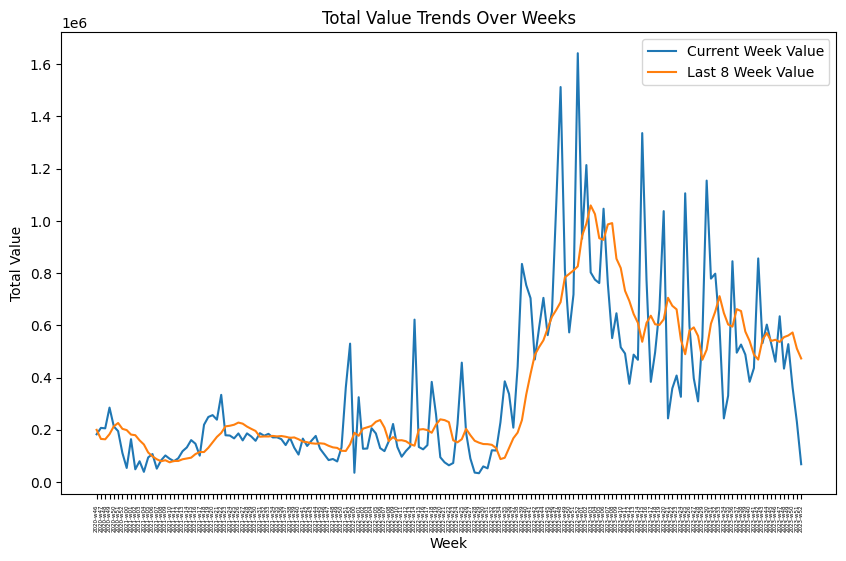

In [47]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Total_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Total Value')
plt.title('Total Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

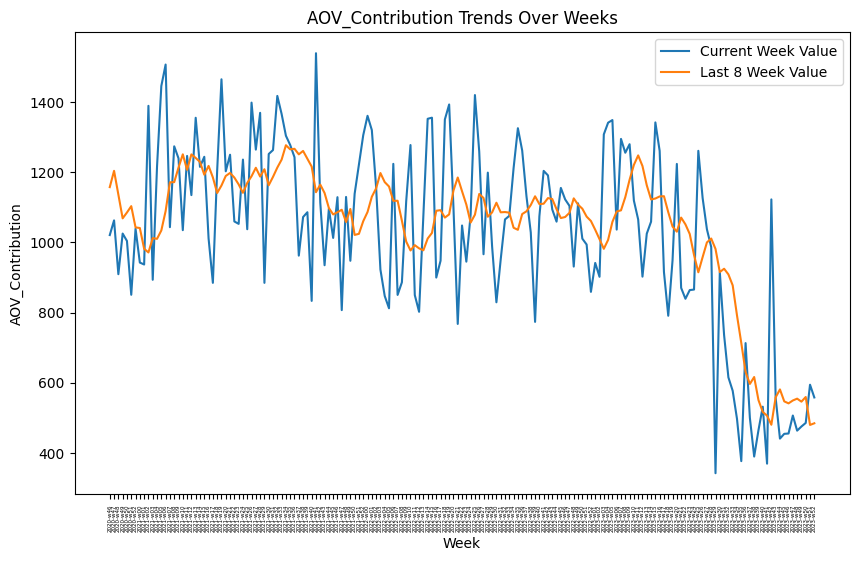

In [48]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'AOV_Contribution']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('AOV_Contribution')
plt.title('AOV_Contribution Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

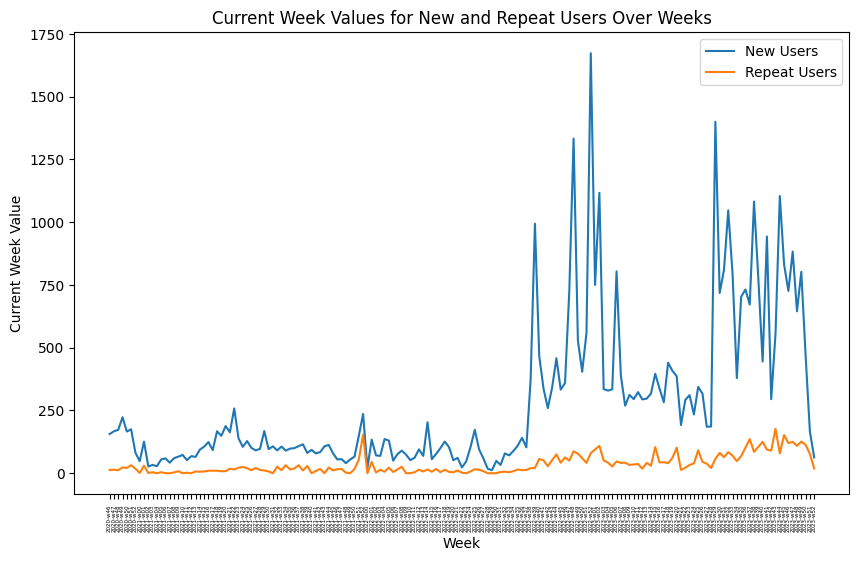

In [49]:
import matplotlib.pyplot as plt

# Filter for 'No_of_New_Users(First_Time_Users)'
new_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_New_Users(First_Time_Users)']

# Filter for 'No_of_Repeat_Users'
repeat_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value' for New Users
plt.plot(new_users_rows['WeekCount'], new_users_rows['Current Week Value'], label='New Users')

# Plot 'WeekCount' versus 'Current Week Value' for Repeat Users
plt.plot(repeat_users_rows['WeekCount'], repeat_users_rows['Current Week Value'], label='Repeat Users')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Current Week Value')
plt.title('Current Week Values for New and Repeat Users Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()


In [50]:
# total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']
# # Plot the graph
# plt.figure(figsize=(10, 6))

# # Plot 'WeekCount' versus 'Current Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# # Plot 'WeekCount' versus 'Last 8 Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# # Set labels and title
# plt.xlabel('Week')
# plt.ylabel('No_of_Repeat_Users')
# plt.title('No_of_Repeat_Users Trends Over Weeks')
# plt.xticks(rotation=90, fontsize=4)
# plt.legend()

# # Show the plot
# plt.show()

In [51]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2020-w46,Churned (Single Use Only)-Low Value & Slow Moving,0.0,0.000,Secondary_Explanatory,Churned (Single Use Only),Low Value & Slow Moving
1,2020-w46,Churned (Single Use Only)-High Value & Slow Mo...,0.0,0.000,Secondary_Explanatory,Churned (Single Use Only),High Value & Slow Moving
2,2020-w46,Churned (Single Use Only)-High Repeat Products,0.0,73.125,Secondary_Explanatory,Churned (Single Use Only),High Repeat Products
4,2020-w46,Champions-Hero,4999.0,1832.000,Secondary_Explanatory,Champions,Hero
5,2020-w46,Churned (Single Use Only)-New Business Drivers,0.0,24602.500,Secondary_Explanatory,Churned (Single Use Only),New Business Drivers
...,...,...,...,...,...,...,...
4940,2023-w52,Champions-New Business Drivers,15395.0,63164.500,Secondary_Explanatory,Champions,New Business Drivers
4941,2023-w52,Champions-Hero,21890.0,90714.875,Secondary_Explanatory,Champions,Hero
4946,2023-w52,Churned (Repeat Use)-New Business Drivers,0.0,2978.125,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
4948,2023-w52,New-Low Value & Slow Moving,0.0,1338.375,Secondary_Explanatory,New,Low Value & Slow Moving


In [52]:
# # Group the data by Product Cohort Labels
# grouped_data = new_df_1.groupby('Product_Cohort_Lables')

# # Plot the data for each Product Cohort Label
# plt.figure(figsize=(12, 8))

# for label, group in grouped_data:
#     plt.plot(group['WeekCount'], group['Current Week Value'], label=label)

# plt.xlabel('Week Count')
# plt.ylabel('Current Week Value')
# plt.title('Current Week Value for Each Product Cohort Label')
# plt.legend(title='Product Cohort Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

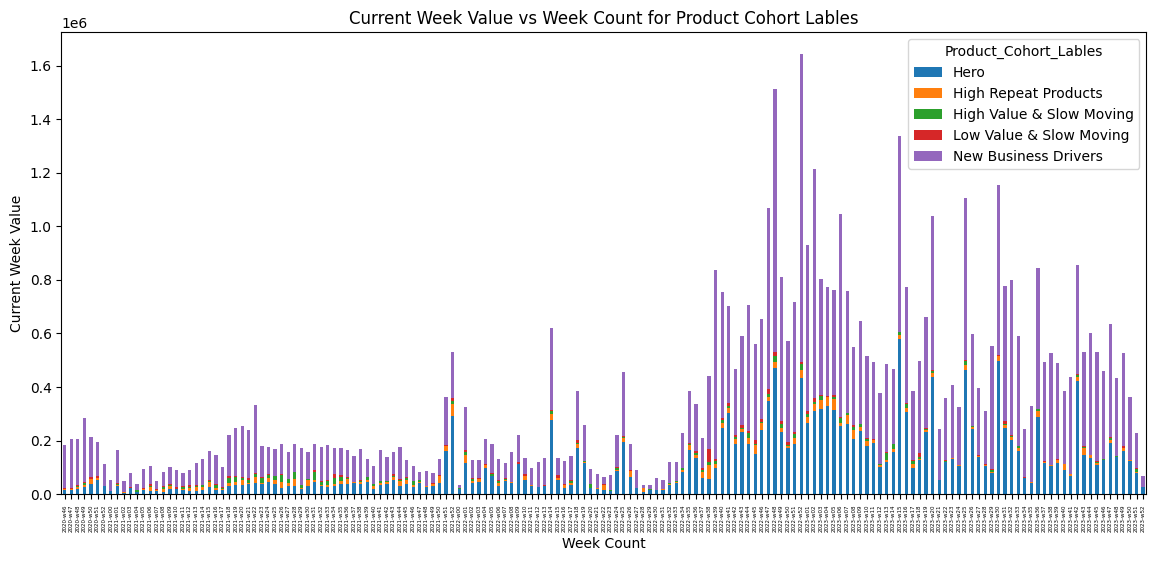

In [53]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x', labelsize=4)
plt.show()

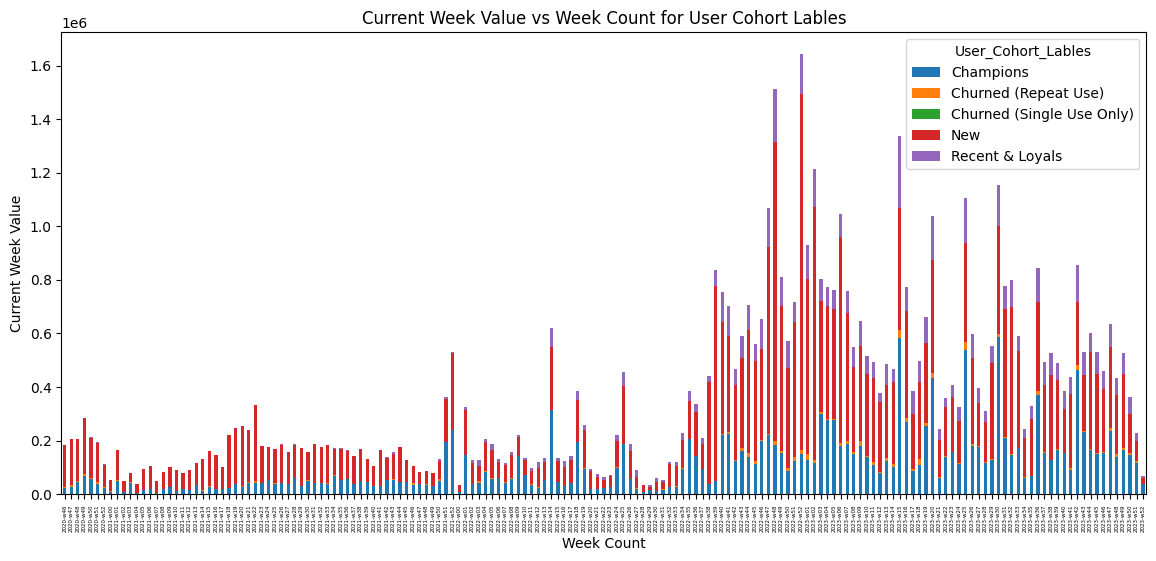

In [54]:
df_agg_user = new_df_1.groupby(['WeekCount', 'User_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df_user = df_agg_user.pivot(index='WeekCount', columns='User_Cohort_Lables', values='Current Week Value')
ax_user = pivot_df_user.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for User Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax_user.tick_params(axis='x', labelsize=4)
plt.show()

In [55]:
merged_dataframe['Variables'] = merged_dataframe.apply(lambda row: row['Variables'].replace('-', '<>') + f'({target_vars[0]})', axis=1)

In [56]:
averages_dict["2023-w52"]

,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),AOV_Contribution
key,,,,,
Champions-Hero,59.375,90714.875,0.000,0.000,97.765867
Champions-High Repeat Products,1.750,2954.500,0.000,0.000,3.520636
Champions-High Value & Slow Moving,0.375,1487.500,0.000,0.000,2.287602
Champions-Low Value & Slow Moving,0.625,744.125,0.000,0.000,0.637443
Champions-New Business Drivers,72.125,63164.500,0.000,0.000,69.159475
Churned (Repeat Use)-Hero,2.750,3333.625,0.000,0.000,3.925556
Churned (Repeat Use)-High Repeat Products,0.250,662.500,0.000,0.000,0.579303
Churned (Repeat Use)-High Value & Slow Moving,0.000,0.000,0.000,0.000,0.000000
Churned (Repeat Use)-Low Value & Slow Moving,0.000,0.000,0.000,0.000,0.000000


In [57]:
grouped_dict["2023-w44"].loc["Champions-Hero"]

Total_Orders                            55.000000
Total_Value                          86510.000000
No_of_Repeat_Users                       0.000000
No_of_New_Users(First_Time_Users)        0.000000
AOV_Contribution                        63.238304
Name: Champions-Hero, dtype: float64